# **Métricas e avaliação de Modelos**

### Avaliação dos Erros

1. **Transformação para a escala original**  
   Inicialmente, transformamos a predição de volta para a escala original dos dados:  
   
   $\hat{y} = \exp(y_{\text{log}})$

2. **Cálculo dos resíduos**  
   A partir de \(\hat{y}\), obtemos os resíduos e erros no instante \(t\) (tanto no treino quanto no teste):  
   
   $e_t = y_t - \hat{y}_t$

3. **Cálculo das métricas**  
   Com os resíduos, podemos calcular as métricas de avaliação dos erros do modelo.

---

### Escolha das Métricas para previsão pontual

Optamos por utilizar **erros escalados**, pois eles permitem comparar o desempenho do modelo em relação a um benchmark básico. Além disso, esse tipo de métrica pode ser útil em trabalhos futuros.  

As métricas selecionadas foram:  
- **Erro Absoluto Médio Escalado (MASE)**  
- **Raiz do Erro Quadrático Médio Escalado (RMSSE)** 

### Escolha de Métricas para previsão distribucional
Com a finalidade de medir outras características dos modelos além de previsões pontuais, selecionamos as demais métricas para quantificar a distribuição das saídas

- **Erro Quantil:** Avaliação dos quantis da distribuição.
- **Wrinkler Score:** Avaliação dos intervalos de predição.
- **Continuous Ranked Probability Score (CRPS):** Avaliação da distribuição preditiva como um todo.

In [4]:
import numpy as np
from properscoring import crps_ensemble
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def scaled_errors(y_true, y_pred, m=12):
    """
    Retorna os erros escalados dado um período sazonal.
    """
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    T = len(y_true)
    
    seasonal_diff_sum = np.sum(np.abs(y_true[m:] - y_true[:-m]))
    scale = (1 / (T - m)) * seasonal_diff_sum
    errors = y_true - y_pred
    q = errors / scale
    
    return q


def mase(q):
    """ 
    Retorna os erros absolutos médios escalados.
    """
    
    return np.mean(np.abs(q))
    
    
def rmsse(q):
    """ 
    Retorna os RMSSEs. 
    """
    
    return np.sqrt(np.mean(q**2))


def winkler_score(y_true, lower, upper, alpha=0.05):
    """ 
    Retorna o Winkler Score dos valores.
    """
    
    y_true = np.array(y_true)
    lower = np.array(lower)
    upper = np.array(upper)
    
    ws = np.zeros_like(y_true, dtype=float)
    
    # Dentro do intervalo
    inside = (y_true >= lower) & (y_true <= upper)
    ws[inside] = upper[inside] - lower[inside]
    
    # Abaixo do intervalo
    below = y_true < lower
    ws[below] = (upper[below] - lower[below]) + (2 / alpha) * (lower[below] - y_true[below])
    
    # Acima do intervalo
    above = y_true > upper
    ws[above] = (upper[above] - lower[above]) + (2 / alpha) * (y_true[above] - upper[above])
    
    return ws, np.mean(ws)

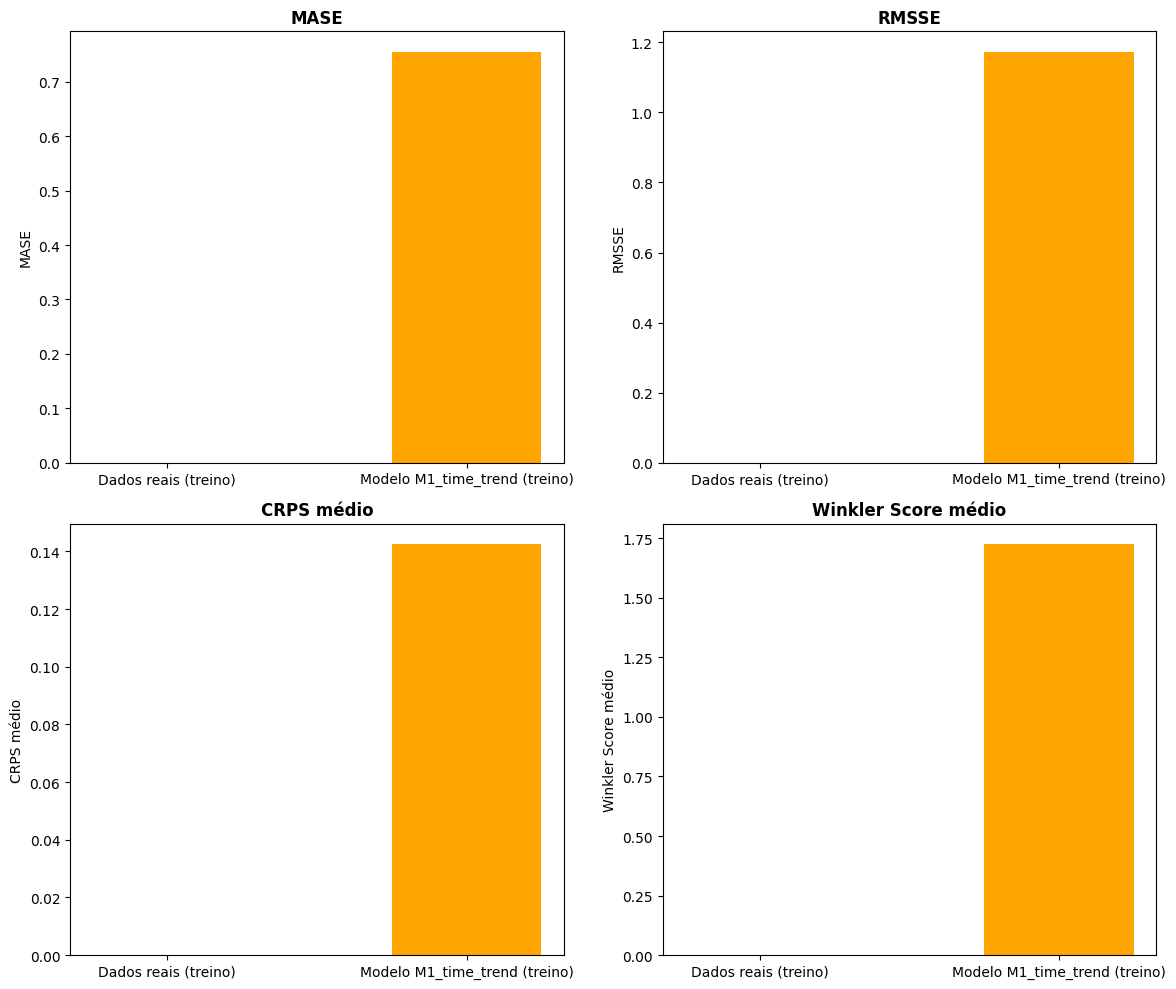

In [ ]:
def compare_models_metrics(model_list):
    nomes = []
    mase_vals = []
    rmsse_vals = []
    crps_vals = []
    winkler_vals = []

    # Definindo cores fixas para cada modelo
    cores = ['skyblue', 'orange', 'green', 'purple', 'red', 'brown']

    for model in model_list:
        nome = model['nome_modelo']
        y_true = np.array(model['y_true'])
        y_pred = np.array(model['y_pred'])
        y_dist = np.array(model['y_dist'])

        q = scaled_errors(y_true, y_pred)
        mase_vals.append(mase(q))
        rmsse_vals.append(rmsse(q))
        crps_vals.append(np.mean(crps_ensemble(y_true, y_dist)))

        lower = np.percentile(y_dist, 5, axis=1)
        upper = np.percentile(y_dist, 95, axis=1)
        _, mean_ws = winkler_score(y_true, lower, upper)
        winkler_vals.append(mean_ws)

        nomes.append(nome)

    width = 0.5
    x = np.arange(len(nomes))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # MASE
    axes[0,0].bar(x, mase_vals, width, color=cores[:len(nomes)])
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(nomes)
    axes[0,0].set_ylabel('MASE')
    axes[0,0].set_title('MASE', weight="bold")

    # RMSSE
    axes[0,1].bar(x, rmsse_vals, width, color=cores[:len(nomes)])
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(nomes)
    axes[0,1].set_ylabel('RMSSE')
    axes[0,1].set_title('RMSSE', weight="bold")

    # CRPS
    axes[1,0].bar(x, crps_vals, width, color=cores[:len(nomes)])
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(nomes)
    axes[1,0].set_ylabel('CRPS médio')
    axes[1,0].set_title('CRPS médio', weight="bold")

    # Winkler Score
    axes[1,1].bar(x, winkler_vals, width, color=cores[:len(nomes)])
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(nomes)
    axes[1,1].set_ylabel('Winkler Score médio')
    axes[1,1].set_title('Winkler Score médio', weight="bold")

    plt.tight_layout()
    plt.show()


# --- Gerando dados fictícios ---
np.random.seed(42)
T = 30
ensemble_size = 10

# y_true com tendência e ruído
y_true = np.linspace(100, 200, T) + np.random.normal(0, 5, T)

# Modelo 1: previsões médias + ensemble
y_pred_model1 = y_true + np.random.normal(0, 5, T)
y_dist_model1 = np.array([y_pred_model1 + np.random.normal(0, 3, T) for _ in range(ensemble_size)]).T

# Modelo 2: previsões com pequeno viés
y_pred_model2 = y_true + np.random.normal(2, 5, T)
y_dist_model2 = np.array([y_pred_model2 + np.random.normal(0, 3, T) for _ in range(ensemble_size)]).T

# --- Criando a lista de modelos ---
model_list = [
    {'nome_modelo': 'Modelo 1', 'y_true': y_true, 'y_pred': y_pred_model1, 'y_dist': y_dist_model1},
    {'nome_modelo': 'Modelo 2', 'y_true': y_true, 'y_pred': y_pred_model2, 'y_dist': y_dist_model2}
]

# --- Chamando a função ---
compare_models_metrics(model_list)


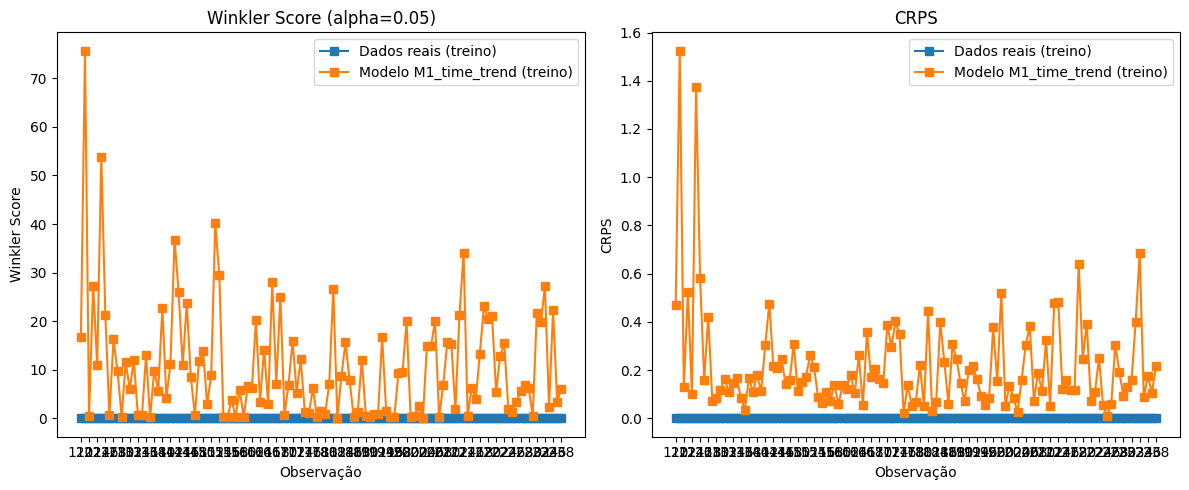

In [ ]:
def plot_models_metrics(model_list, alpha=0.05, x_start=120, tick_step=2):
    """
    Plota Winkler Score e CRPS para vários modelos.
    
    Parâmetros:
    - model_list: lista de modelos com 'y_true' e 'y_dist'
    - alpha: nível de confiança para Winkler Score
    - x_start: valor inicial do eixo x
    - tick_step: passo entre os ticks do eixo x
    """
    plt.figure(figsize=(12, 5))
    n_obs = len(model_list[0]['y_true']) 

    # Winkler Score
    plt.subplot(1, 2, 1)
    for model in model_list:
        y_true = np.array(model['y_true'])
        lower = np.array([interval[0] for interval in model['y_dist']])
        upper = np.array([interval[1] for interval in model['y_dist']])
        ws_values, avg_ws = winkler_score(y_true, lower, upper, alpha)
        plt.plot(np.arange(x_start, x_start + n_obs), ws_values, marker='s', label=model['nome_modelo'])
    
    plt.title(f'Winkler Score (alpha={alpha})')
    plt.xlabel('Observação')
    plt.ylabel('Winkler Score')
    plt.legend()
    plt.xticks(np.arange(x_start, x_start + n_obs, tick_step))  

    # CRPS
    plt.subplot(1, 2, 2)
    for model in model_list:
        y_true = np.array(model['y_true'])
        y_dist = np.array([[interval[0], interval[1]] for interval in model['y_dist']])
        crps_values = crps_ensemble(y_true, y_dist)
        plt.plot(np.arange(x_start, x_start + n_obs), crps_values, marker='s', label=model['nome_modelo'])
    
    plt.title('CRPS')
    plt.xlabel('Observação')
    plt.ylabel('CRPS')
    plt.legend()
    plt.xticks(np.arange(x_start, x_start + n_obs, tick_step))  

    plt.tight_layout()
    plt.show()

plot_models_metrics(model_list, alpha=0.05)